# Random Forest Classifier for Mice Protein Expression Dataset

This notebook implements a Random Forest classifier for the Mice Protein Expression dataset from UCI (https://archive.ics.uci.edu/dataset/342/mice+protein+expression), as required for the VU Machine Learning 2025S assignment. The dataset contains 1080 measurements of 77 protein expression levels in the cerebral cortex of mice, across 8 classes based on genotype (control/trisomy), behavior (context-shock/shock-context), and treatment (memantine/saline). The code follows the lecture steps:
- **Data Import**: Load the dataset and handle missing values.
- **Data Exploration**: Check class distribution, missing values, and feature statistics.
- **Preprocessing**: Impute missing values, scale features, encode classes.
- **Classification**: Run Random Forest with multiple parameter settings.
- **Evaluation**: Use accuracy, F1-score, ROC-AUC, cross-validation, and runtime metrics.
- **Visualization**: Generate confusion matrix and parameter impact plots.

**Objective**: Classify mice into 8 classes based on protein expression levels.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import time
import os
%matplotlib inline

## Step 2: Data Exploration

Load the dataset and explore class distribution, missing values, and feature statistics.


Dataset Shape: (1080, 82)

First 5 Rows:
   MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3  0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4  0.173627   2.134014  0.192158  ...  0.110694  0.434154   0.118481   

     EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior   class  
0  0.131790 

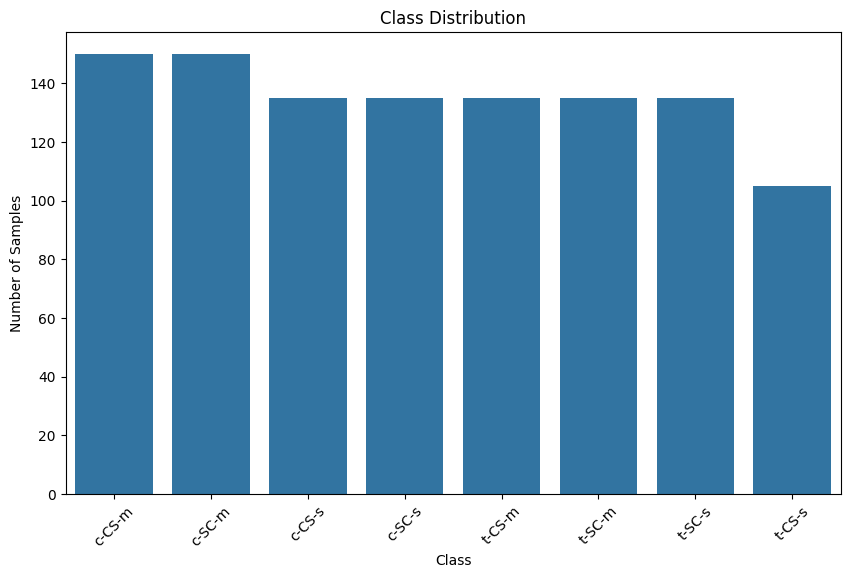


Missing Values:
 DYRK1A_N        3
ITSN1_N         3
BDNF_N          3
NR1_N           3
NR2A_N          3
pAKT_N          3
pBRAF_N         3
pCAMKII_N       3
pCREB_N         3
pELK_N          3
pERK_N          3
pJNK_N          3
PKCA_N          3
pMEK_N          3
pNR1_N          3
pNR2A_N         3
pNR2B_N         3
pPKCAB_N        3
pRSK_N          3
AKT_N           3
BRAF_N          3
CAMKII_N        3
CREB_N          3
ELK_N          18
ERK_N           3
GSK3B_N         3
JNK_N           3
MEK_N           7
TRKA_N          3
RSK_N           3
APP_N           3
Bcatenin_N     18
SOD1_N          3
MTOR_N          3
P38_N           3
pMTOR_N         3
DSCR1_N         3
AMPKA_N         3
NR2B_N          3
pNUMB_N         3
RAPTOR_N        3
TIAM1_N         3
pP70S6_N        3
BAD_N         213
BCL2_N        285
pCFOS_N        75
H3AcK18_N     180
EGR1_N        210
H3MeK4_N      270
dtype: int64

Feature Statistics:
           DYRK1A_N      ITSN1_N       BDNF_N        NR1_N       N

In [2]:
def explore_dataset(df):
    """Explore dataset structure, class distribution, and missing values."""
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['class'].value_counts()
    print("\nClass Distribution:\n", class_counts)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.savefig('class_distribution_mice.png')
    plt.show()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Feature statistics
    print("\nFeature Statistics:\n", df.describe())

# Load dataset
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
df = pd.read_excel(data_url)

# Explore dataset
explore_dataset(df)

## Step 3: Preprocessing

Handle missing values, encode the target variable, scale features, and split data into training and testing sets.

In [3]:
def preprocess_data(df):
    """Preprocess the dataset: impute missing values, encode target, scale features, split data."""
    # Separate features and target
    feature_cols = [col for col in df.columns if col not in ['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class']]
    X = df[feature_cols]
    y = df['class']
    
    # Impute missing values with mean
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    print("\nMissing values after imputation:\n", X_imputed.isnull().sum().sum())
    
    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print("\nClasses:", le.classes_)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, le

# Preprocess data
X_train, X_test, y_train, y_test, le = preprocess_data(df)


Missing values after imputation:
 0

Classes: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']

Training samples: 864, Testing samples: 216


## Step 4: Random Forest Experiments

Run Random Forest with different parameter settings, evaluate using holdout and cross-validation.

In [5]:
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names):
    """Run Random Forest experiments with different parameter settings."""
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize results storage
    results = []
    
    # Experiment with parameter settings
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        
                        # Initialize classifier
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        
                        # Measure training time
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        
                        # Holdout evaluation
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        
                        # Performance metrics
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        
                        # Cross-validation (5-fold)
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        
                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        
                        # Print results
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results


## Step 5: Visualize and Save Results

Save results to CSV, visualize confusion matrix and parameter impact for the best model.

In [6]:
def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names):
    """Visualize results and save to CSV."""
    # Convert results to DataFrame, preserving None for max_depth
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    print("\nmax_depth values:\n", results_df['max_depth'].value_counts(dropna=False))
    
    # Save results
    results_df.to_csv("rf_results_mice.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    max_depth_value = results_df.loc[best_idx]['max_depth']
    # Convert NaN to None for max_depth
    if pd.isna(max_depth_value):
        max_depth_value = None
    else:
        max_depth_value = int(max_depth_value) if max_depth_value is not None else None
    
    print(f"\nBest model max_depth: {max_depth_value}")
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth_value,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_mice.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_mice.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_mice.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_mice.png')
    plt.show()


## Step 6: Main Execution

Run experiments and visualize results.


=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.49s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.98, F1-Score: 0.98, ROC-AUC: 1.00, CV Accuracy: 0.97
Training Time: 0.40s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.99, F1-Score: 0.99, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.37s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.98, F1-Score: 0.98, ROC-AUC: 1.00, CV Accuracy: 0.98
Training Time: 0.37s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.98,

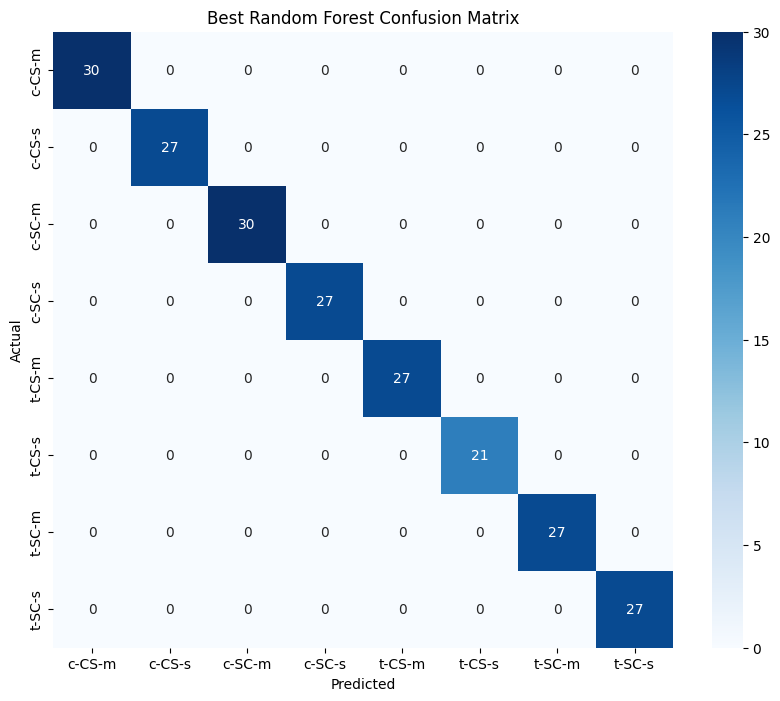


Classification Report for Best Model:
              precision    recall  f1-score   support

      c-CS-m       1.00      1.00      1.00        30
      c-CS-s       1.00      1.00      1.00        27
      c-SC-m       1.00      1.00      1.00        30
      c-SC-s       1.00      1.00      1.00        27
      t-CS-m       1.00      1.00      1.00        27
      t-CS-s       1.00      1.00      1.00        21
      t-SC-m       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        27

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



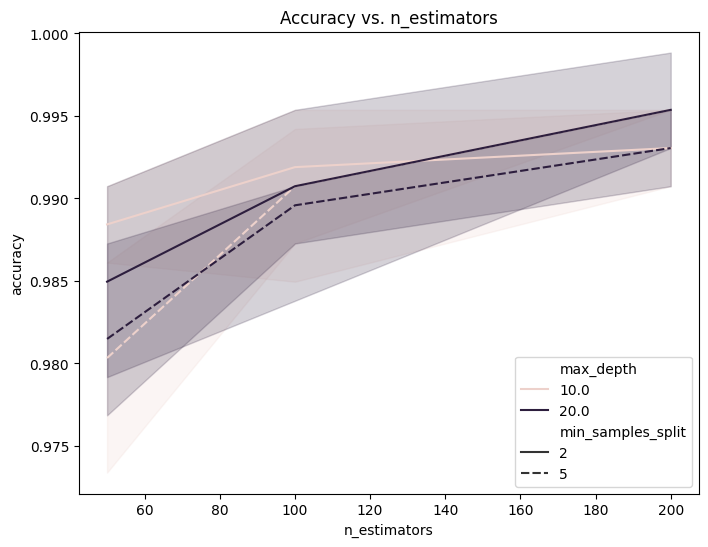

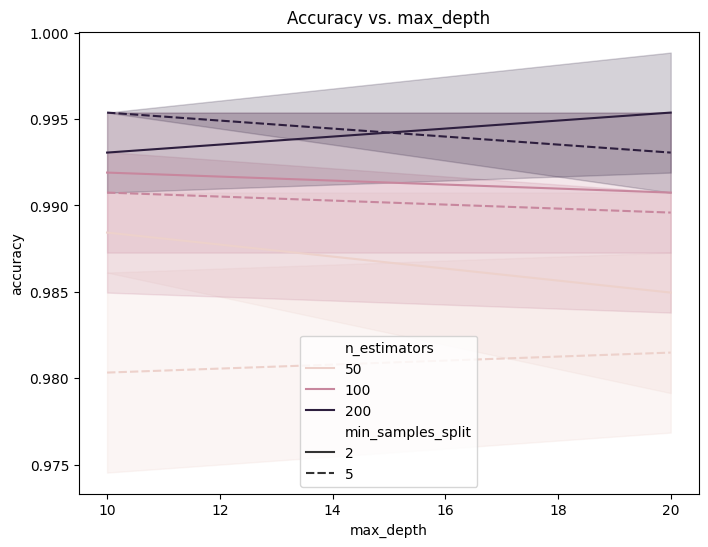

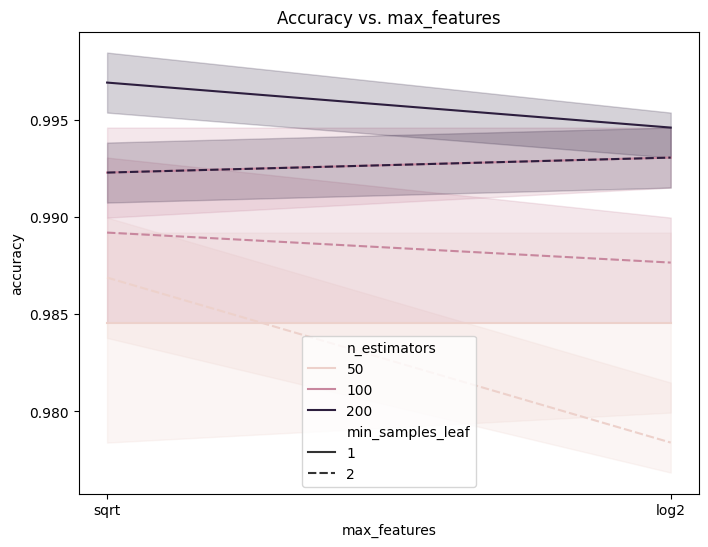

In [7]:
# Run experiments
results = run_rf_experiments(X_train, y_train, X_test, y_test, le.classes_)

# Visualize and save results
visualize_and_save_results(results, X_train, y_train, X_test, y_test, le.classes_)